In [85]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
# sc = SparkContext('local')
# spark = SparkSession(sc)

In [86]:
%matplotlib inline
now = datetime.datetime.now()
print(now)
df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)

2019-07-12 13:19:19.853494


In [87]:
for i in df1.columns:
    if i not in df2.columns:
        df1 = df1.drop(i)
        
for i in df2.columns:
    if i not in df1.columns:
        df2 = df2.drop(i)

In [88]:
len(df1.columns) == len(df2.columns)

True

In [89]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

double_columns = ['bldgarea', 'facilfar','residfar', 'commfar', 
                  'numbldgs', 'numfloors', 'bldgdepth','bldgfront', 
                  'lotdepth', 'lotfront','exemptland', 'exempttot', 
                  'assessland', 'assesstot','builtfar']
cols = df2.columns
df1 = df1.select(cols)
df2 = df2.select(cols)

for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    
df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

colnames = zip(df1.columns, df2.columns)

df = df2.join(df1, df2['bbl'] == df1['bbl_1'])
condo = df.filter(df['lot'].rlike(r'^75'))

In [91]:
df.select('ct2010', 'ct2010_1').show(5)

+------+--------+
|ct2010|ct2010_1|
+------+--------+
|170.12|       0|
|  null|   11900|
|208.01|   20801|
|   706|   70600|
|   638|   63800|
+------+--------+
only showing top 5 rows



In [92]:
df.select('xcoord', 'xcoord_1', 'ycoord', 'ycoord_1').show(5)

+------+--------+------+--------+
|xcoord|xcoord_1|ycoord|ycoord_1|
+------+--------+------+--------+
|982743|    null|197371|    null|
|982046|    null|197756|    null|
|984543|    null|198701|    null|
|982043|    null|199872|    null|
|982562|    null|201003|    null|
+------+--------+------+--------+
only showing top 5 rows



In [96]:
df.select('bbl', 'appbbl', 'appbbl_1', 'sanborn', 'sanborn_1').show(5)

+----------+----------+----------+-------+---------+
|       bbl|    appbbl|  appbbl_1|sanborn|sanborn_1|
+----------+----------+----------+-------+---------+
|1000760008|         0|      null|101S012|   101201|
|1000787502|1000780031|1000780031|11S 011|   10111S|
|1001160046|         0|      null|101S029|   102901|
|1001457501|1001451001|1001451001|101S017|   101701|
|1001770024|         0|      null|101S036|   103601|
+----------+----------+----------+-------+---------+
only showing top 5 rows



In [95]:
df.select('firecomp', 'firecomp_1', 'tract2010', 'tract2010_1', 'sanitdistrict', 'sanitdistrict_1').show(5)

+--------+----------+---------+-----------+-------------+---------------+
|firecomp|firecomp_1|tract2010|tract2010_1|sanitdistrict|sanitdistrict_1|
+--------+----------+---------+-----------+-------------+---------------+
|    E006|       006|     1502|     001502|            1|             01|
|    E006|       006|     1502|     001502|            1|             01|
|    E009|       009|       27|     002700|            3|             03|
|    E007|       007|       21|     002100|            1|             01|
|    E007|       007|       33|     003300|            1|             01|
+--------+----------+---------+-----------+-------------+---------------+
only showing top 5 rows



In [28]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0
    
access_cols = ['exemptland', 'exempttot', 'assessland', 'assesstot']

@udf #special access column comparison
def compare_a(col1,col2):
    try: 
        if abs(col1 - col2) > 10: 
            return 1
        else: 
            return 0
    except: 
        return 0

In [29]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    if B in access_cols:
        df = df.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        df = df.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])

In [30]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [31]:
elapsed_time/60

2.878042415777842

In [32]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

edesigdate%       1.000000
version%          1.000000
basempdate%       1.000000
landmkdate%       1.000000
zoningdate%       1.000000
dcasdate%         1.000000
rpaddate%         1.000000
ct2010%           0.999599
sanborn%          0.999156
xcoord%           0.998819
ycoord%           0.998819
firecomp%         0.998323
assesstot%        0.991262
condono%          0.989826
tract2010%        0.972933
landuse%          0.953943
appbbl%           0.893643
assessland%       0.852219
sanitdistrict%    0.579533
ext%              0.526553
exempttot%        0.452934
residfar%         0.438938
ownername%        0.319260
schooldist%       0.121443
appdate%          0.080494
sanitsub%         0.043851
taxmap%           0.042828
cb2010%           0.040313
council%          0.037772
cd%               0.037724
Name: 0, dtype: float64

In [33]:
elapsed_time/60

2.878042415777842

In [34]:
results0 = pd.read_csv('results_18v1_18v2_1.csv', index_col = False)

In [56]:
results0['mappluto_f%'] = 1
results0['rpaddate%'] = 1
results0['dcasdate%'] = 1
results0['zoningdate%'] = 1
results0['basempdate%'] = 1
results0['masdate%'] = 1
results0['polidate%'] = 1
results0['edesigdate%'] = 1
results0['landmkdate%'] = 1

In [57]:
set(results0.columns) == set(results_df.columns)

True

In [58]:
cols = results_df.columns

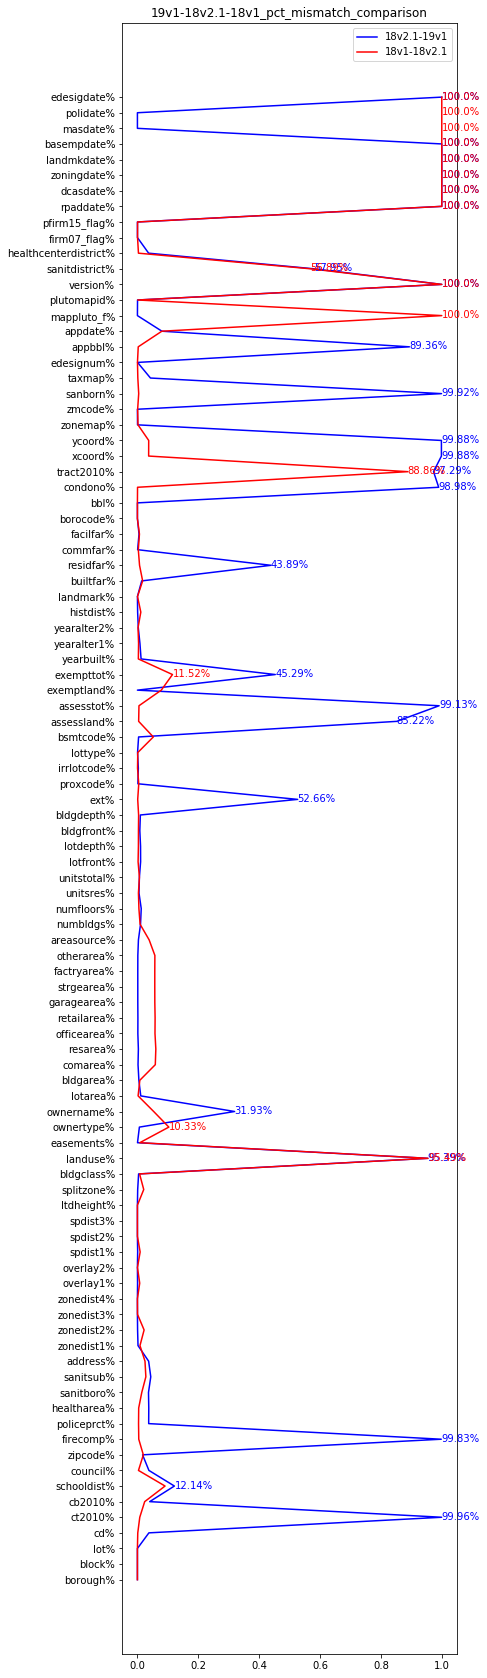

In [62]:
plt.figure(figsize=(6, 30))

plt.plot(results_df.loc[0, cols], range(len(cols)), label = '18v2.1-19v1', color = 'blue')
plt.plot(results0.loc[0, cols], range(len(cols)), label = '18v1-18v2.1', color = 'red')

label = list(results_df.loc[0, cols])
label0 = list(results0.loc[0, cols])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(len(cols)), cols, rotation='horizontal')
plt.legend()
plt.title('19v1-18v2.1-18v1_pct_mismatch_comparison')
plt.savefig('19v1-18v2.1-18v1_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()

# Checks for condos

In [69]:
for A,B in colnames:
    if B in access_cols:
        condo = condo.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        condo = condo.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
condo_results = condo.select(*[mean(col(A)).alias(A) for A in condo.columns])

In [70]:
start_time = time.time()
condo_results_df = condo_results.toPandas()
elapsed_time = time.time() - start_time

In [72]:
elapsed_time/60

1.2874580820401509

In [73]:
condo_results_df.iloc[0,:].sort_values(ascending=False)[0:30]

edesigdate%       1.000000
basempdate%       1.000000
landmkdate%       1.000000
zoningdate%       1.000000
dcasdate%         1.000000
rpaddate%         1.000000
version%          1.000000
ct2010%           0.999919
sanborn%          0.999757
firecomp%         0.998866
ycoord%           0.998379
xcoord%           0.998379
assesstot%        0.990844
tract2010%        0.988899
landuse%          0.979337
ownername%        0.729763
sanitdistrict%    0.688113
assessland%       0.654728
exempttot%        0.649461
builtfar%         0.615023
lotarea%          0.614456
lotfront%         0.614051
lotdepth%         0.613159
yearbuilt%        0.600276
numfloors%        0.581071
appdate%          0.549955
bldgfront%        0.399806
bldgdepth%        0.399238
condono%          0.329471
appbbl%           0.301272
Name: 0, dtype: float64

In [75]:
condo_results0 = pd.read_csv('condo_results_18v1_18v2_1.csv', index_col = False)
condo_results0['mappluto_f%'] = 1
condo_results0['rpaddate%'] = 1
condo_results0['dcasdate%'] = 1
condo_results0['zoningdate%'] = 1
condo_results0['basempdate%'] = 1
condo_results0['masdate%'] = 1
condo_results0['polidate%'] = 1
condo_results0['edesigdate%'] = 1
condo_results0['landmkdate%'] = 1

In [80]:
set(condo_results0.columns) == set(condo_results_df.columns)

True

In [83]:
condo_cols = condo_results_df.columns

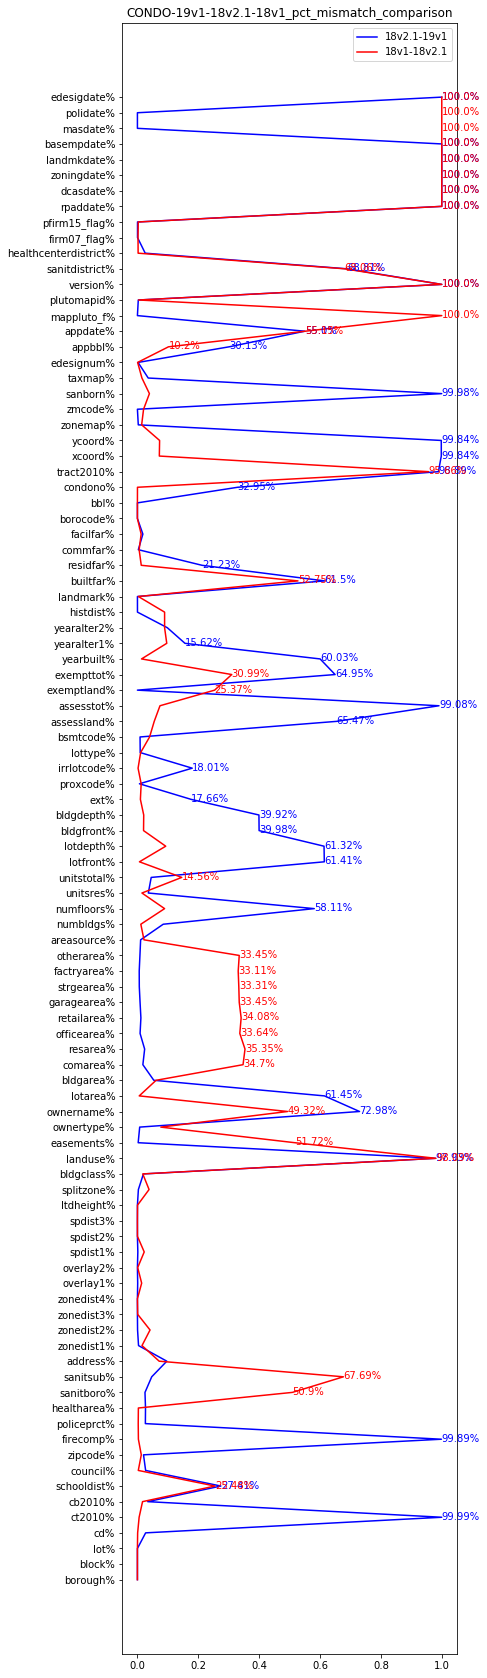

In [84]:
plt.figure(figsize=(6, 30))

plt.plot(condo_results_df.loc[0, condo_cols], range(len(condo_cols)), label = '18v2.1-19v1', color = 'blue')
plt.plot(condo_results0.loc[0, condo_cols], range(len(condo_cols)), label = '18v1-18v2.1', color = 'red')

label = list(condo_results_df.loc[0, condo_cols])
label0 = list(condo_results0.loc[0, condo_cols])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(len(label0)):
    if label0[i] >= 0.1:
        plt.text(x = label0[i] , y = i-0.15, s = '{}%'.format(np.round(label0[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(len(condo_cols)), condo_cols, rotation='horizontal')
plt.legend()
plt.title('CONDO-19v1-18v2.1-18v1_pct_mismatch_comparison')
plt.savefig('CONDO-19v1-18v2.1-18v1_pct_mismatch_comparison.png', bbox_inches='tight')
plt.show()